In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns

1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [2]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [3]:
data= pd.read_csv('data/data_000637.txt',nrows=39000)
print(data)

       HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0         1     0          123  3869200167        2374        26
1         1     0          124  3869200167        2374        27
2         1     0           63  3869200167        2553        28
3         1     0           64  3869200167        2558        19
4         1     0           64  3869200167        2760        25
...     ...   ...          ...         ...         ...       ...
38995     1     0           63  3869200555        1252        11
38996     1     0           64  3869200555        1251        28
38997     1     0           57  3869200555        1872        19
38998     1     0           58  3869200555        1873        22
38999     1     0           60  3869200555        1885        13

[39000 rows x 6 columns]


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [4]:
bc=max(data["BX_COUNTER"])+1
print("Estimated number of BX in a ORBIT: ",bc)

Estimated number of BX in a ORBIT:  3564


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [5]:
tstamp = pd.Timestamp(dt.datetime.now())
zero=data['TDC_CHANNEL'].loc[data.index[0]]*(25/30)+data['BX_COUNTER'].loc[data.index[0]]*25+data['ORBIT_CNT'].loc[data.index[0]]*25*bc #initial value
data["as nanosec"]=(data["TDC_CHANNEL"]*(25/30)+data["BX_COUNTER"]*25+data["ORBIT_CNT"]*bc*25)-zero #time for each row
data["as time"]= pd.to_datetime(data["as nanosec"]+tstamp.value,unit='ns') #nanosec to time formula 

display(data)


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,as nanosec,as time
0,1,0,123,3869200167,2374,26,0.000000e+00,2022-12-02 21:20:48.392845056
1,1,0,124,3869200167,2374,27,8.125000e-01,2022-12-02 21:20:48.392845056
2,1,0,63,3869200167,2553,28,4.425000e+03,2022-12-02 21:20:48.392849408
3,1,0,64,3869200167,2558,19,4.550812e+03,2022-12-02 21:20:48.392849664
4,1,0,64,3869200167,2760,25,9.600812e+03,2022-12-02 21:20:48.392854784
...,...,...,...,...,...,...,...,...
38995,1,0,63,3869200555,1252,11,3.454270e+07,2022-12-02 21:20:48.427387648
38996,1,0,64,3869200555,1251,28,3.454268e+07,2022-12-02 21:20:48.427387648
38997,1,0,57,3869200555,1872,19,3.455820e+07,2022-12-02 21:20:48.427403264
38998,1,0,58,3869200555,1873,22,3.455822e+07,2022-12-02 21:20:48.427403264


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [6]:
itime = dt.datetime.now()
print("Begin time:", itime)

time =  data['TDC_MEAS'] *(25/30) + data['BX_COUNTER'] * 25 + data['ORBIT_CNT']*bc*25
ftime = dt.datetime.now()
print("End time:", ftime)
print("Elapsed time:", ftime - itime)

Begin time: 2022-12-02 21:20:48.437815
End time: 2022-12-02 21:20:48.439814
Elapsed time: 0:00:00.001999


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
annen=data.groupby('TDC_CHANNEL',sort=True).sum()
print(annen.iloc[-3:])

             HEAD  FPGA       ORBIT_CNT  BX_COUNTER  TDC_MEAS    as nanosec
TDC_CHANNEL                                                                
127            38    38    147029613622       72569       656  6.478507e+08
128            40    40    154768013961       75522       541  6.482513e+08
139          3244   975  12551685966102     5768083         0  5.558166e+10


C:\Users\dehak\AppData\Local\Temp\ipykernel_16900\3859452177.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  annen=data.groupby('TDC_CHANNEL',sort=True).sum()


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [8]:
non_empty_orbits = data.groupby('ORBIT_CNT').size()
print("Non-empty orbits length:", len(non_empty_orbits)) 

Non-empty orbits length: 389


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [9]:
channel_139_orbits = data[data['TDC_CHANNEL'] == 139].groupby('ORBIT_CNT').size()
print("TDC_CHANNEL 139 orbits length: ", len(channel_139_orbits))


TDC_CHANNEL 139 orbits length:  389


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [10]:
display(data[data['FPGA']==1].value_counts('TDC_CHANNEL'))
display(data[data['FPGA']==0].value_counts('TDC_CHANNEL'))

TDC_CHANNEL
139    975
2      943
1      849
4      773
3      682
      ... 
84       2
82       1
86       1
91       1
94       1
Length: 128, dtype: int64

TDC_CHANNEL
139    2269
64     1927
63     1901
61     1442
62     1409
       ... 
103      15
106      14
109      12
101       8
67        4
Length: 118, dtype: int64

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

<AxesSubplot: xlabel='TDC_CHANNEL', ylabel='Count'>

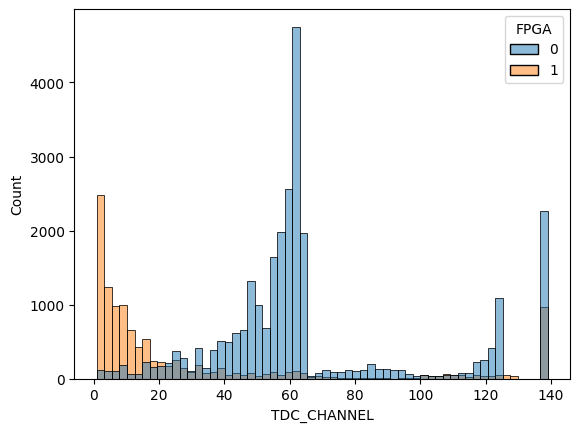

In [11]:
sns.histplot(data=data, x='TDC_CHANNEL', hue='FPGA')